### Performance on Onboarding
---



In [1]:
# pip install --index-url https://build.sofi.com/artifactory/api/pypi/pypi/simple -r ../../requirements.txt --use-deprecated=legacy-resolver

In [2]:
import sys, os, json
sys.path.insert(1, "../../")
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings("ignore")
from src.combine import combine_data
from src.monitoring.download_customer_prod import download_customer_prod_data

%matplotlib inline
plt.style.use('seaborn')

%load_ext autoreload
%autoreload 2

In [3]:
# load dev data
# dev_df = pd.read_feather("../../data/combined_all_features/combined_1637115975.feather")
dev_df = pd.read_feather("../../data/combined_all_features/combined_1639607188.feather")
dev_df = dev_df[dev_df.sample_date==pd.to_datetime("2021-11-03")]

In [4]:
dev_df.sample_date.value_counts()

2021-11-03    1249357
Name: sample_date, dtype: int64

In [61]:
active_accounts = dev_df[
    (dev_df.nr_past_transactions > 0) & (dev_df.nr_transactions_30d > 0)
].user_id.unique()
dev_df.loc[:, "is_active"] = dev_df.user_id.isin(active_accounts)

(1596151, 57)

<AxesSubplot:>

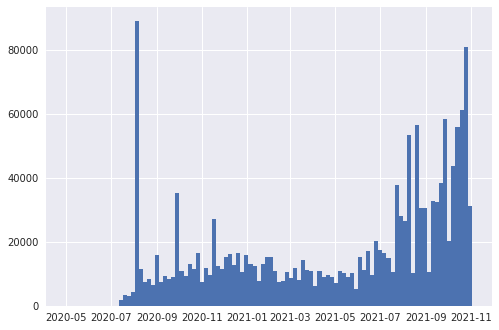

In [5]:
# load prod data
output_path = f"s3://sofi-data-science/jxu/data_dump/money_customer_risk/20210916-dev-prod-alignment/prod_11_02.parquet"
prod_df = pd.read_parquet(output_path)

prod_df["created_date"] = pd.to_datetime(prod_df.created_dt).dt.date
prod_df["last_checked_date"] = pd.to_datetime(prod_df.last_checked_date).dt.date
display(prod_df.shape)
prod_df["created_date"].hist(bins=100)

In [6]:
last_batch_date = pd.to_datetime("2021-10-27")
prod_df_new = prod_df[prod_df.created_date > last_batch_date]

prod_df_new[prod_df_new.request_source=='"onboarding"'].shape

(30468, 57)

#### Mask with Default

In [7]:
default_values = {
    'transaction_as_pct_of_balance': 0,
    'max_withdrawals_30d': 0,
    'max_deposits_30d': 0,
    'pct_returned_deposits': 0,
    'bal_ratio': 0,
    'sum_deposits_10d': 0,
    'mean_account_balance_30d': 0,
    'dollar_val_dd': 0,
    'nr_direct_deposits': 0,
    'nr_past_transactions': -1,  # -1 is the default in production where we have 0 in dev...
    'dollar_val_returns': 0,
    'dollar_val_returns_3d': 0,
    'nr_returns_30d': 0,
    'time_since_last_transaction': -1,
    'nr_trans_ratio': -1,
    'first_deposit_amount': -1,
    'lag_acc_open_first_transaction': -1,
    'transaction_code_encoded': 0,  
}

tfts = ['transaction_as_pct_of_balance',
     'time_since_last_transaction',
     'nr_past_transactions',
     'pct_returned_deposits',
     'dollar_val_returns',
     'dollar_val_returns_3d',
     'mean_account_balance_30d',
     'sum_deposits_10d',
     'max_deposits_30d',
     'max_withdrawals_30d',
     'nr_direct_deposits',
     'bal_ratio',
     'dollar_val_dd',
     'nr_returns_30d',
     'nr_trans_ratio',
     'transaction_code_encoded'
]

vcs = {}
for f in default_values:
     vcs[f] = (prod_df_new[f] == default_values[f]).value_counts()
        
is_default_df = pd.concat(vcs).unstack()
is_default_df["pct_default"] = is_default_df[True] / (is_default_df[False] + is_default_df[True])

is_default_df.loc[tfts]

,True,False,pct_default
transaction_as_pct_of_balance,30614,439,0.985863
time_since_last_transaction,30560,493,0.984124
nr_past_transactions,30440,613,0.980260
pct_returned_deposits,31003,50,0.998390
dollar_val_returns,31003,50,0.998390
dollar_val_returns_3d,31014,39,0.998744
mean_account_balance_30d,30596,457,0.985283
sum_deposits_10d,30765,288,0.990726
max_deposits_30d,30762,291,0.990629
max_withdrawals_30d,30727,326,0.989502


In [8]:
new_ids = prod_df_new.party_id.unique()
ids = dev_df.user_id.unique()
no_ids = prod_df_new[prod_df_new.party_id.isin(set(new_ids) - set(ids))]

len(no_ids)

12663

13k users in prod does not appear in dev. Find out why.

In [9]:
no_ids.head()

,party_id,created_dt,updated_dt,last_checked_date,last_checked_date_max,risk_group,request_source,model_score,model_decision_rule_details,mcustomer_model_risk_groupodel_score,...,total_tradelines_open,education_loan_amount,iqt9415,iln5520,iqt9413,credit_card_loan_amount,transaction_code_encoded,all7120_default_encoded,bcc7120_default_encoded,created_date
361,10293997,2021-10-28 15:37:13.614,2021-10-28 19:33:26.233,2021-10-28,2021-10-28 19:33:26.232,"""RG4B""","""onboarding""",592.725389,"[{""ruleName"":""isMember"",""rulePassed"":false,""ri...","""RG4B""",...,24.0,50985.0,1.0,1958.0,0.0,2143.0,0,-1.0,-1.0,2021-10-28
1647,297940,2021-10-28 14:16:39.621,2021-10-28 14:17:36.439,2021-10-28,2021-10-28 14:17:36.437,"""RG5""","""onboarding""",681.032172,"[{""ruleName"":""isMember"",""rulePassed"":false,""ri...","""RG5""",...,0.0,0.0,0.0,NaN,0.0,0.0,0,999.0,999.0,2021-10-28
1863,2601113,2021-10-28 01:47:56.187,2021-10-28 01:48:49.928,2021-10-28,2021-10-28 01:48:49.927,"""RG5""","""onboarding""",682.401465,"[{""ruleName"":""isMember"",""rulePassed"":false,""ri...","""RG5""",...,3.0,3224.0,2.0,1584.0,0.0,0.0,0,-1.0,996.0,2021-10-28
2013,10404642,2021-10-28 03:02:37.658,2021-10-28 03:03:01.159,2021-10-28,2021-10-28 03:03:01.158,"""RG5""","""onboarding""",667.170020,"[{""ruleName"":""isMember"",""rulePassed"":false,""ri...","""RG5""",...,6.0,0.0,2.0,6055.0,1.0,2506.0,0,-1.0,-1.0,2021-10-28
2040,10719932,2021-10-28 02:51:28.096,None,2021-10-28,2021-10-28 02:51:28.094,"""RG5""","""onboarding""",696.981379,"[{""ruleName"":""isMember"",""rulePassed"":false,""ri...","""RG5""",...,NaN,NaN,NaN,NaN,NaN,NaN,0,-1.0,-1.0,2021-10-28


In [10]:
no_ids[no_ids.party_id.isin([10584064,
 20676609,
 20709378])]

,party_id,created_dt,updated_dt,last_checked_date,last_checked_date_max,risk_group,request_source,model_score,model_decision_rule_details,mcustomer_model_risk_groupodel_score,...,total_tradelines_open,education_loan_amount,iqt9415,iln5520,iqt9413,credit_card_loan_amount,transaction_code_encoded,all7120_default_encoded,bcc7120_default_encoded,created_date
123886,10584064,2021-10-28 04:19:43.255,None,2021-10-28,2021-10-28 04:19:43.253,"""RG5""","""onboarding""",636.404050,"[{""ruleName"":""isMember"",""rulePassed"":false,""ri...","""RG5""",...,7.0,38158.0,1.0,26645.0,0.0,204.0,0,-1.0,-1.0,2021-10-28
1455807,20709378,2021-10-31 19:13:59.636,None,2021-10-31,2021-10-31 19:13:59.634,"""RG5""","""onboarding""",660.923098,"[{""ruleName"":""isMember"",""rulePassed"":false,""ri...","""RG5""",...,NaN,NaN,NaN,NaN,NaN,NaN,0,-1.0,-1.0,2021-10-31
1568594,20676609,2021-10-29 02:44:13.353,None,2021-10-29,2021-10-29 02:44:13.351,"""RG5""","""onboarding""",646.506261,"[{""ruleName"":""isMember"",""rulePassed"":false,""ri...","""RG5""",...,NaN,NaN,NaN,NaN,NaN,NaN,0,-1.0,-1.0,2021-10-29


In [11]:
no_ids[no_ids.party_id.isin([10584064,
                             20676609,
                             20709378,
                            19791897])].T

,123886,1442236,1455807,1568594
party_id,10584064,19791897,20709378,20676609
created_dt,2021-10-28 04:19:43.255,2021-10-30 07:14:54.159,2021-10-31 19:13:59.636,2021-10-29 02:44:13.353
updated_dt,None,2021-10-30 07:15:00.060,None,None
last_checked_date,2021-10-28,2021-10-30,2021-10-31,2021-10-29
last_checked_date_max,2021-10-28 04:19:43.253,2021-10-30 07:15:00.058,2021-10-31 19:13:59.634,2021-10-29 02:44:13.351
risk_group,"""RG5""","""RG5""","""RG5""","""RG5"""
request_source,"""onboarding""","""onboarding""","""onboarding""","""onboarding"""
model_score,636.40405,683.208268,660.923098,646.506261
model_decision_rule_details,"[{""ruleName"":""isMember"",""rulePassed"":false,""ri...","[{""ruleName"":""isMember"",""rulePassed"":false,""ri...","[{""ruleName"":""isMember"",""rulePassed"":false,""ri...","[{""ruleName"":""isMember"",""rulePassed"":false,""ri..."
mcustomer_model_risk_groupodel_score,"""RG5""","""RG5""","""RG5""","""RG5"""


In [12]:
bkaccts = pd.read_feather("../../data/raw/raw_1639594789/banking_accounts_1639594789.feather")

In [13]:
len(set(no_ids.party_id).intersection(set(bkaccts.user_id)))

333

In [14]:
declined_new_ids = set(no_ids.party_id.unique()) - set(bkaccts.user_id.unique())
len(declined_new_ids)

12330

In [15]:
df_tmp = prod_df_new[prod_df_new.party_id.isin(declined_new_ids)].head()
df_tmp

,party_id,created_dt,updated_dt,last_checked_date,last_checked_date_max,risk_group,request_source,model_score,model_decision_rule_details,mcustomer_model_risk_groupodel_score,...,total_tradelines_open,education_loan_amount,iqt9415,iln5520,iqt9413,credit_card_loan_amount,transaction_code_encoded,all7120_default_encoded,bcc7120_default_encoded,created_date
361,10293997,2021-10-28 15:37:13.614,2021-10-28 19:33:26.233,2021-10-28,2021-10-28 19:33:26.232,"""RG4B""","""onboarding""",592.725389,"[{""ruleName"":""isMember"",""rulePassed"":false,""ri...","""RG4B""",...,24.0,50985.0,1.0,1958.0,0.0,2143.0,0,-1.0,-1.0,2021-10-28
1647,297940,2021-10-28 14:16:39.621,2021-10-28 14:17:36.439,2021-10-28,2021-10-28 14:17:36.437,"""RG5""","""onboarding""",681.032172,"[{""ruleName"":""isMember"",""rulePassed"":false,""ri...","""RG5""",...,0.0,0.0,0.0,NaN,0.0,0.0,0,999.0,999.0,2021-10-28
1863,2601113,2021-10-28 01:47:56.187,2021-10-28 01:48:49.928,2021-10-28,2021-10-28 01:48:49.927,"""RG5""","""onboarding""",682.401465,"[{""ruleName"":""isMember"",""rulePassed"":false,""ri...","""RG5""",...,3.0,3224.0,2.0,1584.0,0.0,0.0,0,-1.0,996.0,2021-10-28
2013,10404642,2021-10-28 03:02:37.658,2021-10-28 03:03:01.159,2021-10-28,2021-10-28 03:03:01.158,"""RG5""","""onboarding""",667.170020,"[{""ruleName"":""isMember"",""rulePassed"":false,""ri...","""RG5""",...,6.0,0.0,2.0,6055.0,1.0,2506.0,0,-1.0,-1.0,2021-10-28
2040,10719932,2021-10-28 02:51:28.096,None,2021-10-28,2021-10-28 02:51:28.094,"""RG5""","""onboarding""",696.981379,"[{""ruleName"":""isMember"",""rulePassed"":false,""ri...","""RG5""",...,NaN,NaN,NaN,NaN,NaN,NaN,0,-1.0,-1.0,2021-10-28


In [16]:
from pprint import pprint

In [17]:
i = 0
drd = df_tmp.model_decision_rule_details.iloc[i]
pprint(json.loads(drd))

[{'riskGroupCode': 'RG1', 'ruleName': 'isMember', 'rulePassed': False},
 {'riskGroupCode': 'RG1', 'ruleName': 'noRecentAch', 'rulePassed': True},
 {'riskGroupCode': 'RG1', 'ruleName': 'notHighRisk', 'rulePassed': True},
 {'riskGroupCode': 'RG1', 'ruleName': 'isPlMoneyBundle', 'rulePassed': False},
 {'riskGroupCode': 'RG1', 'ruleName': 'allPass', 'rulePassed': False}]


In [18]:
new_df_w_tgt = pd.merge(prod_df_new, dev_df[["user_id", "target"]],
                        left_on="party_id", right_on="user_id", how="inner",
                        suffixes=("", "_"))

In [19]:
# missing 12k records... where are they? 
# - we looked at a many and all are declined by decision rules
new_df_w_tgt.target.value_counts()

False    18411
True        24
Name: target, dtype: int64

In [20]:
from src.monitoring.utils import preprocess, scale_scores

new_df_w_tgt_default = new_df_w_tgt.copy(deep=True)
for f in default_values:
    print(f)
    new_df_w_tgt_default[f] = default_values[f]
new_df_w_tgt_default = preprocess(new_df_w_tgt_default)

transaction_as_pct_of_balance
max_withdrawals_30d
max_deposits_30d
pct_returned_deposits
bal_ratio
sum_deposits_10d
mean_account_balance_30d
dollar_val_dd
nr_direct_deposits
nr_past_transactions
dollar_val_returns
dollar_val_returns_3d
nr_returns_30d
time_since_last_transaction
nr_trans_ratio
first_deposit_amount
lag_acc_open_first_transaction
transaction_code_encoded


#### Eval

In [21]:
import pickle as pkl
from smart_open import open

incumbent_model_path = "s3://sofi-data-science/jxu/money-risk-models/models/customer_risk_target_no_giact_time_since_last_link.pkl"
with open(incumbent_model_path, "rb") as f:
    incumbent_model = pkl.load(f)
    
refit_model_path = "s3://sofi-data-science/jxu/money-risk-models/models/customer_risk_refit_20201231_wo_ind.pkl"
with open(refit_model_path, "rb") as f:
    refit_model = pkl.load(f)

In [22]:
# original
new_df_w_tgt["refitted_model_pred"] = refit_model.predict_proba(new_df_w_tgt[refit_model.feature_name_])[:,1]
new_df_w_tgt["refitted_model_score"] = scale_scores(new_df_w_tgt["refitted_model_pred"])

new_df_w_tgt["incumbent_model_pred"] = incumbent_model.predict_proba(new_df_w_tgt[incumbent_model.feature_name_])[:,1]
new_df_w_tgt["incumbent_model_score"] = scale_scores(new_df_w_tgt["incumbent_model_pred"])

In [23]:
# overwritten with default
new_df_w_tgt["refitted_model_pred_w_default"] = refit_model.predict_proba(new_df_w_tgt_default[refit_model.feature_name_])[:,1]
new_df_w_tgt["refitted_model_score_w_default"] = scale_scores(new_df_w_tgt["refitted_model_pred_w_default"])

new_df_w_tgt["incumbent_model_pred_w_default"] = incumbent_model.predict_proba(new_df_w_tgt_default[incumbent_model.feature_name_])[:,1]
new_df_w_tgt["incumbent_model_score_w_default"] = scale_scores(new_df_w_tgt["incumbent_model_pred_w_default"])

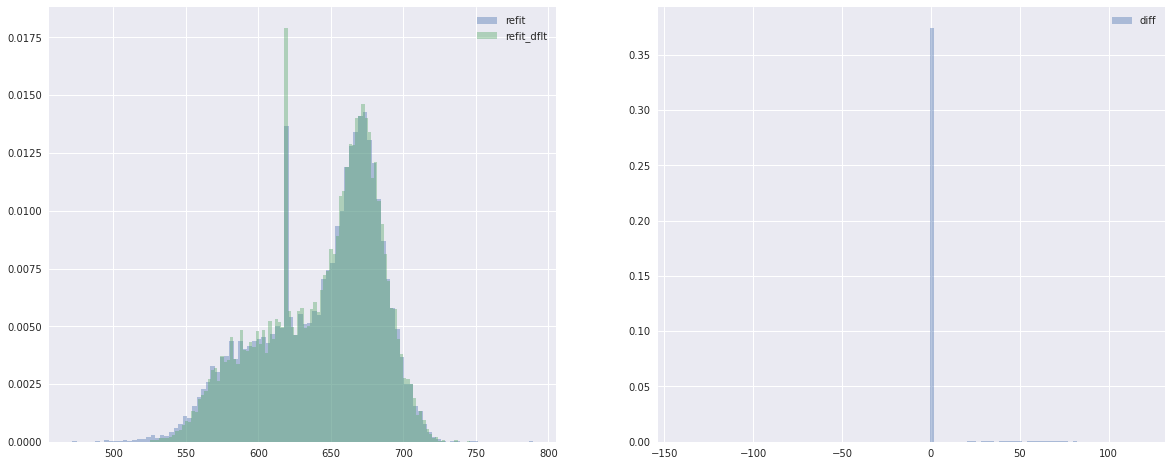

In [24]:
fig, axs = plt.subplots(1, 2, figsize=(20, 8))

plt_params = {"alpha": 0.4,
              "bins": 100,
              "density": True}

ax = axs[0]
new_df_w_tgt["refitted_model_score"].hist(**plt_params, label="refit", ax=ax)
new_df_w_tgt["refitted_model_score_w_default"].hist(**plt_params, label="refit_dflt", ax=ax)
ax.legend()

ax = axs[1]
diff = new_df_w_tgt["refitted_model_score_w_default"] - new_df_w_tgt["refitted_model_score"]
diff.hist(**plt_params, label="diff", ax=ax)
ax.legend()

In [25]:
diff.value_counts(normalize=True)

 0.000000     0.970925
-0.469390     0.000325
 34.629524    0.000108
 1.550379     0.000108
-0.134054     0.000108
                ...   
-30.168112    0.000054
 85.335794    0.000054
 39.220636    0.000054
 74.987206    0.000054
-10.683662    0.000054
Length: 528, dtype: float64

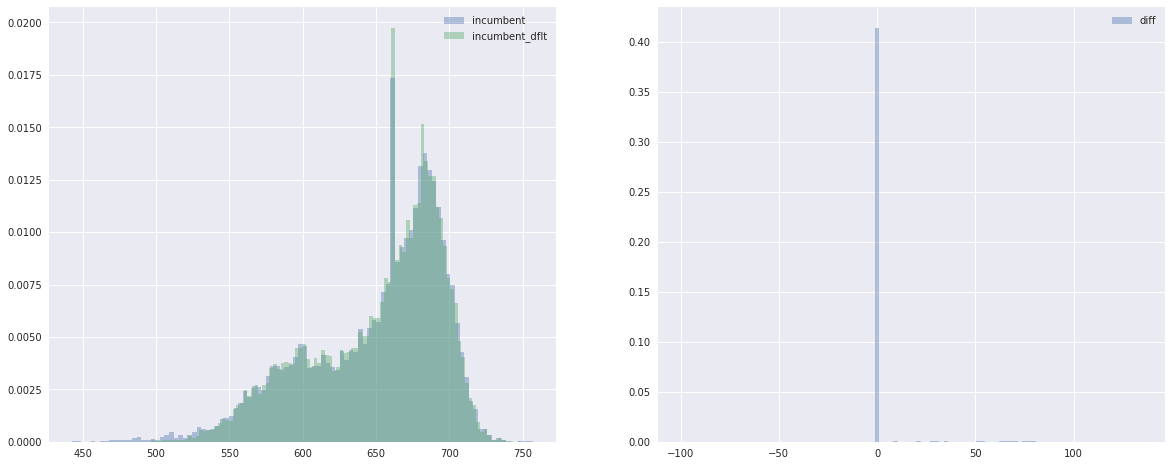

In [26]:
fig, axs = plt.subplots(1, 2, figsize=(20, 8))

plt_params = {"alpha": 0.4,
              "bins": 100,
              "density": True}

ax = axs[0]
new_df_w_tgt["incumbent_model_score"].hist(**plt_params, label="incumbent", ax=ax)
new_df_w_tgt["incumbent_model_score_w_default"].hist(**plt_params, label="incumbent_dflt", ax=ax)
ax.legend()

ax = axs[1]
diff = new_df_w_tgt["incumbent_model_score_w_default"] - new_df_w_tgt["incumbent_model_score"]
diff.hist(**plt_params, label="diff", ax=ax)
ax.legend()

In [27]:
cond_ = new_df_w_tgt["incumbent_model_score"] == new_df_w_tgt["incumbent_model_score"].value_counts().index[0]
new_df_w_tgt[cond_][incumbent_model.feature_name_]

,first_deposit_amount,vantage_score,bcc7120,email_risk_score,fraud_score_2,name_email_correlation,transaction_as_pct_of_balance,mean_account_balance_30d,phone_risk_score,name_address_correlation,...,nr_trans_ratio,iqt9413,dollar_val_returns_3d,nr_returns_30d,credit_card_loan_amount,fraud_score_1,age_money_account,transaction_code_encoded,all7120_default_encoded,bcc7120_default_encoded
59,-1.0,NaN,NaN,NaN,NaN,NaN,0.0,0.0,NaN,NaN,...,-1.0,NaN,0.0,0.0,NaN,NaN,NaN,0,-1.0,-1.0
72,-1.0,NaN,NaN,NaN,NaN,NaN,0.0,0.0,NaN,NaN,...,-1.0,NaN,0.0,0.0,NaN,NaN,NaN,0,-1.0,-1.0
129,-1.0,NaN,NaN,NaN,NaN,NaN,0.0,0.0,NaN,NaN,...,-1.0,NaN,0.0,0.0,NaN,NaN,0.0,0,-1.0,-1.0
211,-1.0,NaN,NaN,NaN,NaN,NaN,0.0,0.0,NaN,NaN,...,-1.0,NaN,0.0,0.0,NaN,NaN,NaN,0,-1.0,-1.0
231,-1.0,NaN,NaN,NaN,NaN,NaN,0.0,0.0,NaN,NaN,...,-1.0,NaN,0.0,0.0,NaN,NaN,NaN,0,-1.0,-1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
18223,-1.0,NaN,NaN,NaN,NaN,NaN,0.0,0.0,NaN,NaN,...,-1.0,NaN,0.0,0.0,NaN,NaN,NaN,0,-1.0,-1.0
18297,-1.0,NaN,NaN,NaN,NaN,NaN,0.0,0.0,NaN,NaN,...,-1.0,NaN,0.0,0.0,NaN,NaN,NaN,0,-1.0,-1.0
18412,-1.0,NaN,NaN,NaN,NaN,NaN,0.0,0.0,NaN,NaN,...,-1.0,NaN,0.0,0.0,NaN,NaN,0.0,0,-1.0,-1.0
18413,-1.0,NaN,NaN,NaN,NaN,NaN,0.0,0.0,NaN,NaN,...,-1.0,NaN,0.0,0.0,NaN,NaN,0.0,0,-1.0,-1.0


In [28]:
diff.value_counts(normalize=True)

 0.000000     0.971467
 67.066865    0.000108
-17.189655    0.000108
 52.185666    0.000108
 5.849190     0.000108
                ...   
 27.397827    0.000054
 61.078699    0.000054
 76.928837    0.000054
 29.964754    0.000054
-24.427079    0.000054
Length: 523, dtype: float64

In [29]:
(diff.abs() <= 1e-5).value_counts(normalize=True)

True     0.971467
False    0.028533
dtype: float64

In [30]:
# only so many limited targets, needs to look deeper into it

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


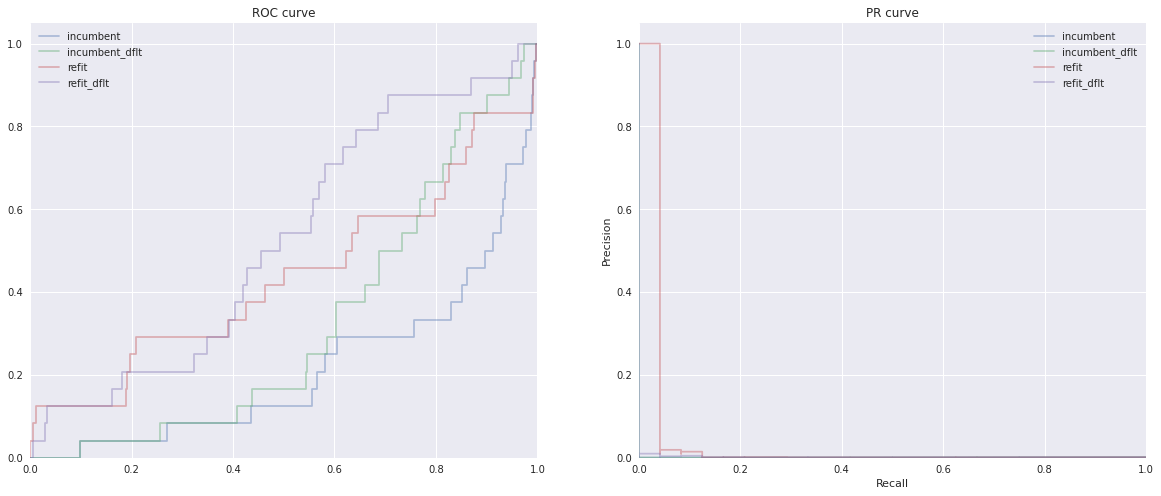

In [31]:
# performance
from rdsutils.plot import plot_auc_curve_mult, plot_pr_curve_mult


fig, axs = plt.subplots(1, 2, figsize=(20,8))
df_ = new_df_w_tgt

preds = [
    (df_['incumbent_model_score'], 'incumbent'),
    (df_['incumbent_model_score_w_default'], 'incumbent_dflt'),
    (df_['refitted_model_score'], 'refit'),
    (df_['refitted_model_score_w_default'], 'refit_dflt'),
]

colors = plt.rcParams['axes.prop_cycle'].by_key()['color'][:len(preds)]
title = 'ROC curve'
plot_auc_curve_mult(df_["target"], preds,
                    title=title, colors=colors,
                    fill_area=False,
                    ax=axs[0])
axs[0].legend()


title = 'PR curve'
plot_pr_curve_mult(df_["target"], preds,
                    title=title, colors=colors,
                    fill_area=False,
                    ax=axs[1])
axs[1].legend()



In [32]:
# how about CM based on RGs?
def get_risk_groups(serie):
    return pd.cut(serie.round(), [300, 474, 510, 560, 600, 850], 
                  right=True, labels=[f'RG{i}' for i in range(1, 6)],
                  include_lowest=True)

def get_risk_groups_refitted(serie):
    return pd.cut(serie.round(), [300, 520, 550, 570, 600, 850],  # new rg proposal
                  right=True, labels=[f'RG{i}' for i in range(1, 6)],
                  include_lowest=True)

new_df_w_tgt["rg_refitted"] = get_risk_groups_refitted(new_df_w_tgt["refitted_model_score"])
new_df_w_tgt["rg_incumbent"] = get_risk_groups(new_df_w_tgt["incumbent_model_score"])

new_df_w_tgt["rg_refitted_w_default"] = get_risk_groups_refitted(new_df_w_tgt["refitted_model_score_w_default"])
new_df_w_tgt["rg_incumbent_w_default"] = get_risk_groups(new_df_w_tgt["incumbent_model_score_w_default"])

nr accounts:  18435
ratio of users kept their RG:  233


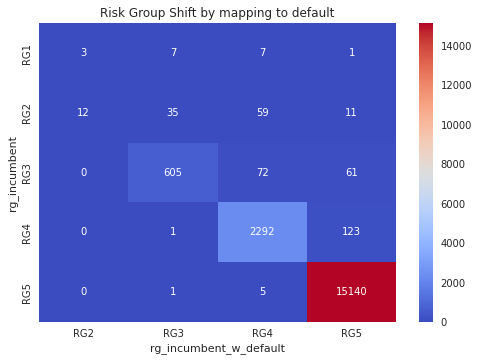

In [33]:
# how about CM based on RGs?
# look at risk groups
import seaborn as sns

rg = "rg_incumbent"
rg_w_default = "rg_incumbent_w_default"

table = df_[[rg, rg_w_default]].value_counts(normalize=False).sort_index().reset_index()
table.columns = [rg, rg_w_default, 'counts']
table = pd.pivot_table(table, values='counts', index=rg, 
                       columns=rg_w_default, fill_value=0)
fig = plt.figure()
sns.heatmap(table, cmap='coolwarm', annot=True, fmt='.6g')
plt.title('Risk Group Shift by mapping to default')

print("nr accounts: ", df_.shape[0])
print("ratio of users kept their RG: ", np.trace(table))

In [51]:
norm = False

nr accounts:  18435
ratio of users kept their RG:  1006


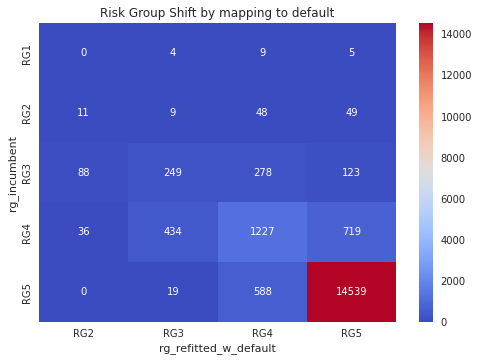

In [52]:
# how about CM based on RGs?
# look at risk groups
import seaborn as sns

rg = "rg_incumbent"
rg_w_default = "rg_refitted_w_default"

table = df_[[rg, rg_w_default]].value_counts(normalize=norm).sort_index().reset_index()
table.columns = [rg, rg_w_default, 'counts']
table = pd.pivot_table(table, values='counts', index=rg, 
                       columns=rg_w_default, fill_value=0)
fig = plt.figure()
sns.heatmap(table, cmap='coolwarm', annot=True, fmt='.6g')
plt.title('Risk Group Shift by mapping to default')

print("nr accounts: ", df_.shape[0])
print("ratio of users kept their RG: ", np.trace(table))

nr accounts:  18435
ratio of users kept their RG:  150


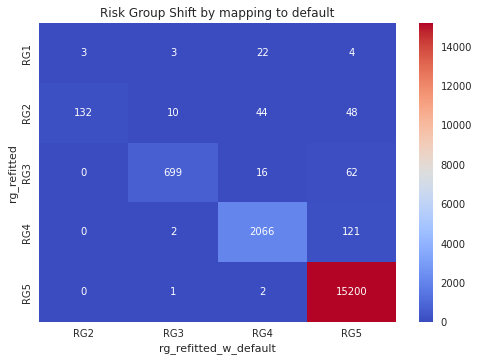

In [53]:
# how about CM based on RGs?
# look at risk groups
import seaborn as sns

rg = "rg_refitted"
rg_w_default = "rg_refitted_w_default"

table = df_[[rg, rg_w_default]].value_counts(normalize=norm).sort_index().reset_index()
table.columns = [rg, rg_w_default, 'counts']
table = pd.pivot_table(table, values='counts', index=rg, 
                       columns=rg_w_default, fill_value=0)
fig = plt.figure()
sns.heatmap(table, cmap='coolwarm', annot=True, fmt='.6g')
plt.title('Risk Group Shift by mapping to default')

print("nr accounts: ", df_.shape[0])
print("ratio of users kept their RG: ", np.trace(table))

#### for the active group

In [62]:
df_.loc[:, "is_active"] = df_.user_id.isin(active_accounts)
df_active = df_[df_.is_active]

nr accounts:  247
ratio of users kept their RG:  78


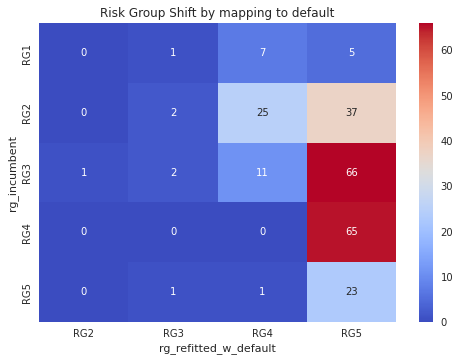

In [64]:
# how about CM based on RGs?
# look at risk groups
import seaborn as sns

rg = "rg_incumbent"
rg_w_default = "rg_refitted_w_default"

table = df_active[[rg, rg_w_default]].value_counts(normalize=norm).sort_index().reset_index()
table.columns = [rg, rg_w_default, 'counts']
table = pd.pivot_table(table, values='counts', index=rg, 
                       columns=rg_w_default, fill_value=0)
fig = plt.figure()
sns.heatmap(table, cmap='coolwarm', annot=True, fmt='.6g')
plt.title('Risk Group Shift by mapping to default')

print("nr accounts: ", df_active.shape[0])
print("ratio of users kept their RG: ", np.trace(table))

nr accounts:  247
ratio of users kept their RG:  65


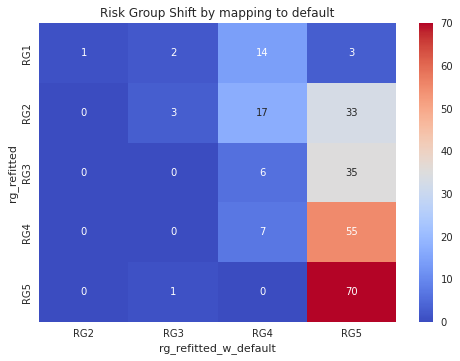

In [65]:
# how about CM based on RGs?
# look at risk groups
import seaborn as sns

rg = "rg_refitted"
rg_w_default = "rg_refitted_w_default"

table = df_active[[rg, rg_w_default]].value_counts(normalize=norm).sort_index().reset_index()
table.columns = [rg, rg_w_default, 'counts']
table = pd.pivot_table(table, values='counts', index=rg, 
                       columns=rg_w_default, fill_value=0)
fig = plt.figure()
sns.heatmap(table, cmap='coolwarm', annot=True, fmt='.6g')
plt.title('Risk Group Shift by mapping to default')

print("nr accounts: ", df_active.shape[0])
print("ratio of users kept their RG: ", np.trace(table))

In [67]:
df_active["incumbent_diff"] = df_active["incumbent_model_score_w_default"] - df_active["incumbent_model_score"]
df_active["refit_diff"] = df_active["refitted_model_score_w_default"] - df_active["refitted_model_score"]

In [82]:
# somes ids to look at: 11035348, 16542303, 12774097, 19871206
df_tmp = df_active.sort_values("incumbent_diff", ascending=False).head()
ids_tmp = df_tmp.party_id.to_list()

In [83]:
pd.set_option('display.max_rows', 100)

df_active[df_active["party_id"].isin(ids_tmp)].T #[tfts].T


,101,2072,3307,4119,4608
party_id,2398759,14907698,18164956,19898692,19861120
created_dt,2021-11-01 06:31:14.838,2021-11-01 21:01:14.450,2021-11-01 06:31:14.825,2021-11-01 04:32:41.029,2021-10-29 04:31:44.499
updated_dt,None,None,None,None,None
last_checked_date,2021-11-01,2021-11-01,2021-11-01,2021-11-01,2021-10-29
last_checked_date_max,2021-11-01 06:31:14.834,2021-11-01 21:01:14.446,2021-11-01 06:31:14.820,2021-11-01 04:32:41.025,2021-10-29 04:31:44.491
risk_group,"""RG3A""","""RG1""","""RG3A""","""RG1""","""RG3A"""
request_source,"""return""","""return""","""return""","""tenure""","""tenure"""
model_score,528.214475,472.129175,514.826259,472.164395,529.233591
model_decision_rule_details,"[{""ruleName"":""isMember"",""rulePassed"":false,""ri...","[{""ruleName"":""isMember"",""rulePassed"":false,""ri...","[{""ruleName"":""isMember"",""rulePassed"":false,""ri...","[{""ruleName"":""isMember"",""rulePassed"":false,""ri...","[{""ruleName"":""isMember"",""rulePassed"":false,""ri..."
mcustomer_model_risk_groupodel_score,"""RG3A""","""RG1""","""RG3A""","""RG1""","""RG3A"""


In [54]:
# rmse
from math import sqrt
sqrt((diff ** 2).mean())

10.175774461163083

In [37]:
diff.abs().mean()

1.484348318327887

##### find more data?

In [38]:
prod_df.head()

,party_id,created_dt,updated_dt,last_checked_date,last_checked_date_max,risk_group,request_source,model_score,model_decision_rule_details,mcustomer_model_risk_groupodel_score,...,total_tradelines_open,education_loan_amount,iqt9415,iln5520,iqt9413,credit_card_loan_amount,transaction_code_encoded,all7120_default_encoded,bcc7120_default_encoded,created_date
0,10835,2021-03-03 03:21:10.145,2021-10-27 02:27:10.380,2021-10-27,2021-10-27 02:27:10.379,"""RG1""","""scheduled""",427.113019,"[{""ruleName"":""isMember"",""rulePassed"":true,""ris...","""RG1""",...,NaN,NaN,NaN,NaN,NaN,NaN,3,-1.0,-1.0,2021-03-03
1,13863,2021-10-27 03:58:06.808,None,2021-10-27,2021-10-27 03:58:06.803,"""RG2B""","""scheduled""",508.070244,"[{""ruleName"":""isMember"",""rulePassed"":false,""ri...","""RG2B""",...,10.0,87623.0,1.0,29248.0,1.0,3488.0,2,-1.0,-1.0,2021-10-27
2,14484,2020-08-05 07:02:57.426,2021-10-27 02:29:44.977,2021-10-27,2021-10-27 02:29:44.976,"""RG1""","""scheduled""",322.498492,"[{""ruleName"":""isMember"",""rulePassed"":true,""ris...","""RG1""",...,14.0,60697.0,0.0,43506.0,0.0,17241.0,3,-1.0,-1.0,2020-08-05
3,21974,2020-08-05 06:17:29.450,2021-10-27 02:07:13.360,2021-10-27,2021-10-27 02:07:13.359,"""RG1""","""scheduled""",441.344522,"[{""ruleName"":""isMember"",""rulePassed"":true,""ris...","""RG1""",...,NaN,NaN,NaN,NaN,NaN,NaN,6,-1.0,-1.0,2020-08-05
4,26586,2020-09-30 02:15:15.361,2021-10-27 02:06:19.168,2021-10-27,2021-10-27 02:06:19.167,"""RG1""","""scheduled""",385.510656,"[{""ruleName"":""isMember"",""rulePassed"":false,""ri...","""RG1""",...,16.0,0.0,1.0,96000.0,0.0,2721.0,0,-1.0,-1.0,2020-09-30


In [39]:
prod_df.request_source.value_counts()

"scheduled"     1236857
"onboarding"     344210
"tenure"          11810
"return"           3269
"adhoc"               5
Name: request_source, dtype: int64

In [40]:
dt_cols = ["created_dt",
        "updated_dt",
        "last_checked_date",
        "last_checked_date_max"]
for d in dt_cols:
    prod_df[d] = pd.to_datetime(prod_df[d])

In [41]:
onboarding_df = prod_df[(prod_df.request_source=='"onboarding"')
                       & (prod_df.created_dt.dt.date==prod_df.last_checked_date.dt.date)]
onboarding_df.shape  

(330226, 57)

<AxesSubplot:>

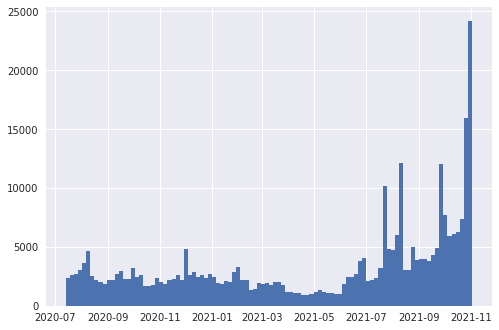

In [42]:
onboarding_df.created_dt.hist(bins=100)

In [43]:
new_df_w_tgt.target.value_counts()

False    18411
True        24
Name: target, dtype: int64

In [44]:
new_df_w_tgt.target.value_counts(normalize=True)

False    0.998698
True     0.001302
Name: target, dtype: float64

In [45]:
dev_df.target.value_counts()

False    1246013
True        3344
Name: target, dtype: int64

In [46]:
dev_df.target.value_counts(normalize=True)

False    0.997323
True     0.002677
Name: target, dtype: float64

In [47]:
# 0.6% 